# Weather Prediction System
## Multi-Target Weather Forecasting Project

### Project Overview
This project implements a multi-target weather forecasting system capable of predicting temperature, humidity, and wind speed simultaneously. The system uses historical weather data and machine learning to generate accurate weather predictions with seasonal awareness.

### Features
- Multi-target prediction (Temperature, Humidity, Wind Speed)
- Seasonal pattern recognition
- 7-day forecast generation
- Visualization of weather patterns
- Statistical analysis of predictions

### Technical Implementation
- Random Forest Regressor with multi-output capability
- Feature engineering for weather prediction
- Seasonal pattern modeling
- Data scaling and preprocessing
- Cross-validation and model evaluation

### Project Structure
1. Data Generation and Preparation
2. Feature Engineering
3. Model Training
4. Prediction System
5. Forecast Generation
6. Visualization Tools
7. Statistical Analysis

### Dependencies
- Python 3.x
- pandas
- numpy
- scikit-learn
- matplotlib
- seaborn
- joblib

### Author
Aryan Dadwal

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better plotting
plt.style.use('default')  # Changed from 'seaborn' to 'default'
%matplotlib inline

# Display all columns in pandas dataframes
pd.set_option('display.max_columns', None)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Generate dates for 3 years of daily data
dates = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')

# Create base patterns for temperature, humidity, and wind speed
def generate_weather_data(dates):
    n_samples = len(dates)
    
    # Convert dates to features
    day_of_year = dates.dayofyear
    month = dates.month
    
    # Temperature pattern (°C)
    # Base temperature with yearly seasonal pattern
    temp_base = 15 + 10 * np.sin(2 * np.pi * day_of_year / 365)
    # Add daily variation and some random noise
    temperature = temp_base + np.random.normal(0, 2, n_samples)
    
    # Humidity pattern (%)
    # Base humidity with seasonal pattern (inverse to temperature)
    humidity_base = 70 - 10 * np.sin(2 * np.pi * day_of_year / 365)
    # Add variation and random noise
    humidity = humidity_base + np.random.normal(0, 5, n_samples)
    # Clip humidity to realistic range
    humidity = np.clip(humidity, 30, 100)
    
    # Wind speed pattern (km/h)
    # Base wind speed with seasonal pattern
    wind_base = 15 + 5 * np.sin(2 * np.pi * day_of_year / 365)
    # Add variation and random noise
    wind_speed = wind_base + np.random.normal(0, 3, n_samples)
    # Clip wind speed to non-negative values
    wind_speed = np.clip(wind_speed, 0, None)
    
    # Create DataFrame
    weather_data = pd.DataFrame({
        'date': dates,
        'temperature': temperature,
        'humidity': humidity,
        'wind_speed': wind_speed,
        'month': month,
        'day_of_year': day_of_year
    })
    
    return weather_data

# Generate the dataset
weather_df = generate_weather_data(dates)

# Display the first few rows and basic information
print("First few rows of the dataset:")
print(weather_df.head())
print("\nDataset Info:")
print(weather_df.info())
print("\nBasic statistics:")
print(weather_df.describe())

First few rows of the dataset:
        date  temperature   humidity  wind_speed  month  day_of_year
0 2020-01-01    16.165562  70.221042   21.158996      1            1
1 2020-01-02    15.067688  59.664780   11.082586      1            2
2 2020-01-03    16.811574  74.065442   15.827217      1            3
3 2020-01-04    18.734084  71.044418   13.358066      1            4
4 2020-01-05    15.391341  74.130403   16.707486      1            5

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1096 non-null   datetime64[ns]
 1   temperature  1096 non-null   float64       
 2   humidity     1096 non-null   float64       
 3   wind_speed   1096 non-null   float64       
 4   month        1096 non-null   int32         
 5   day_of_year  1096 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int

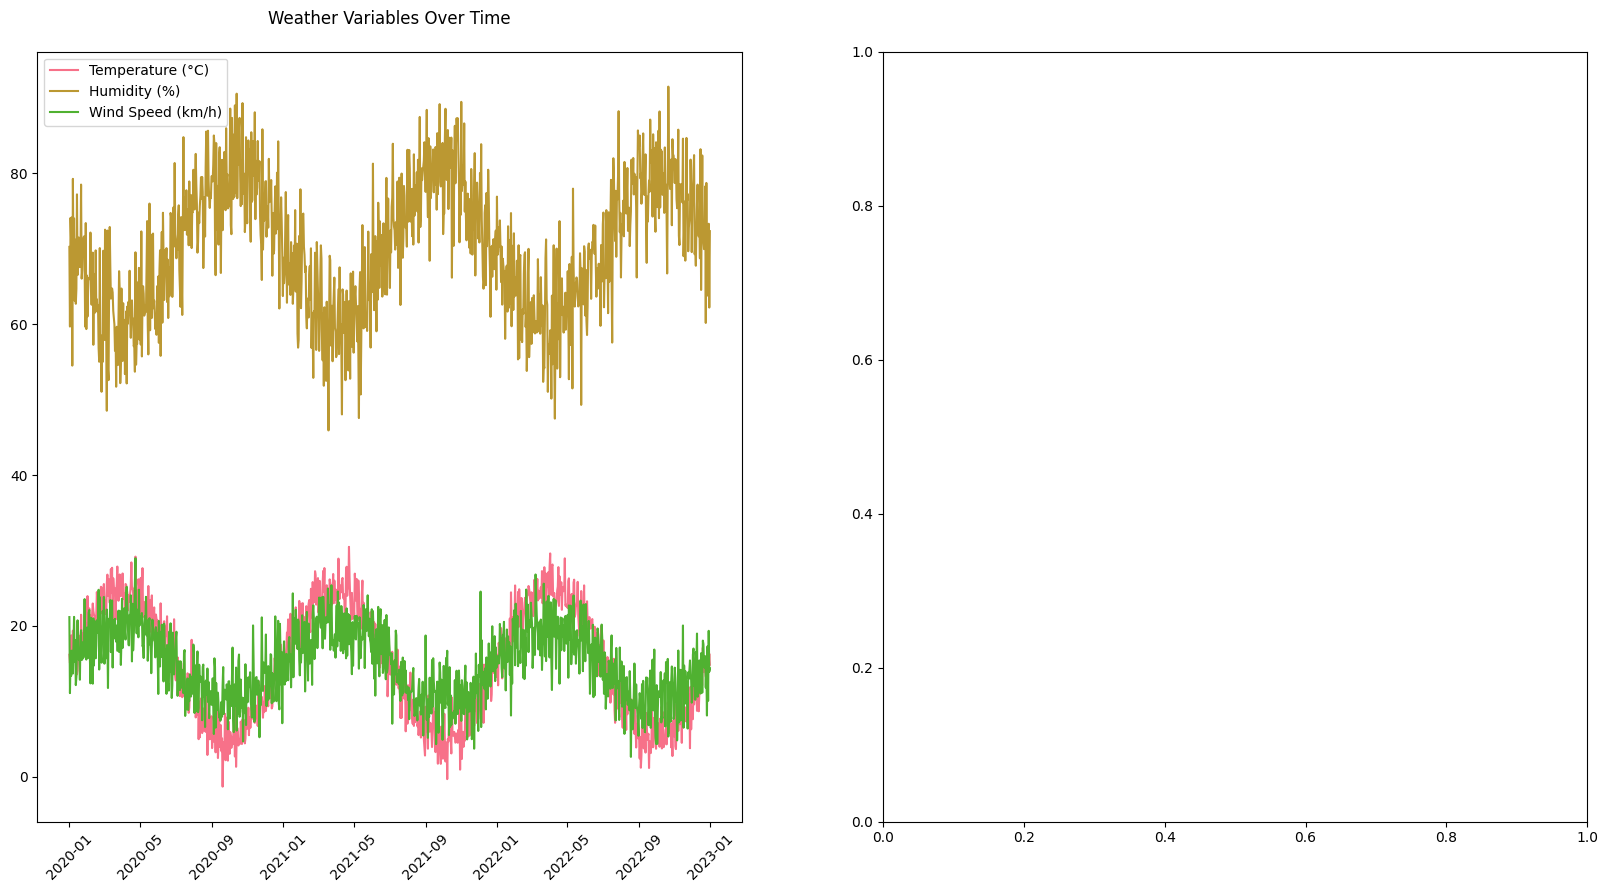

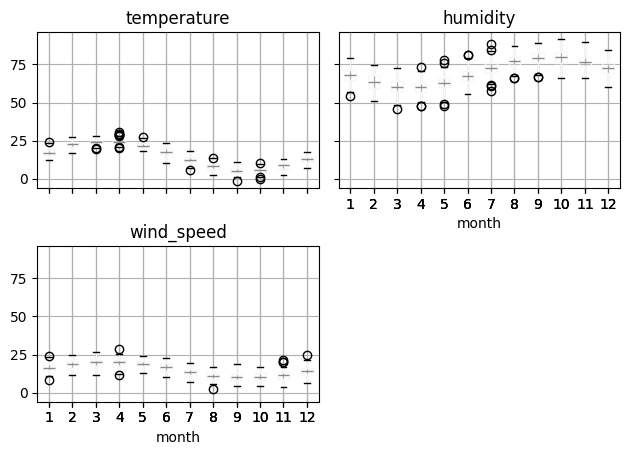

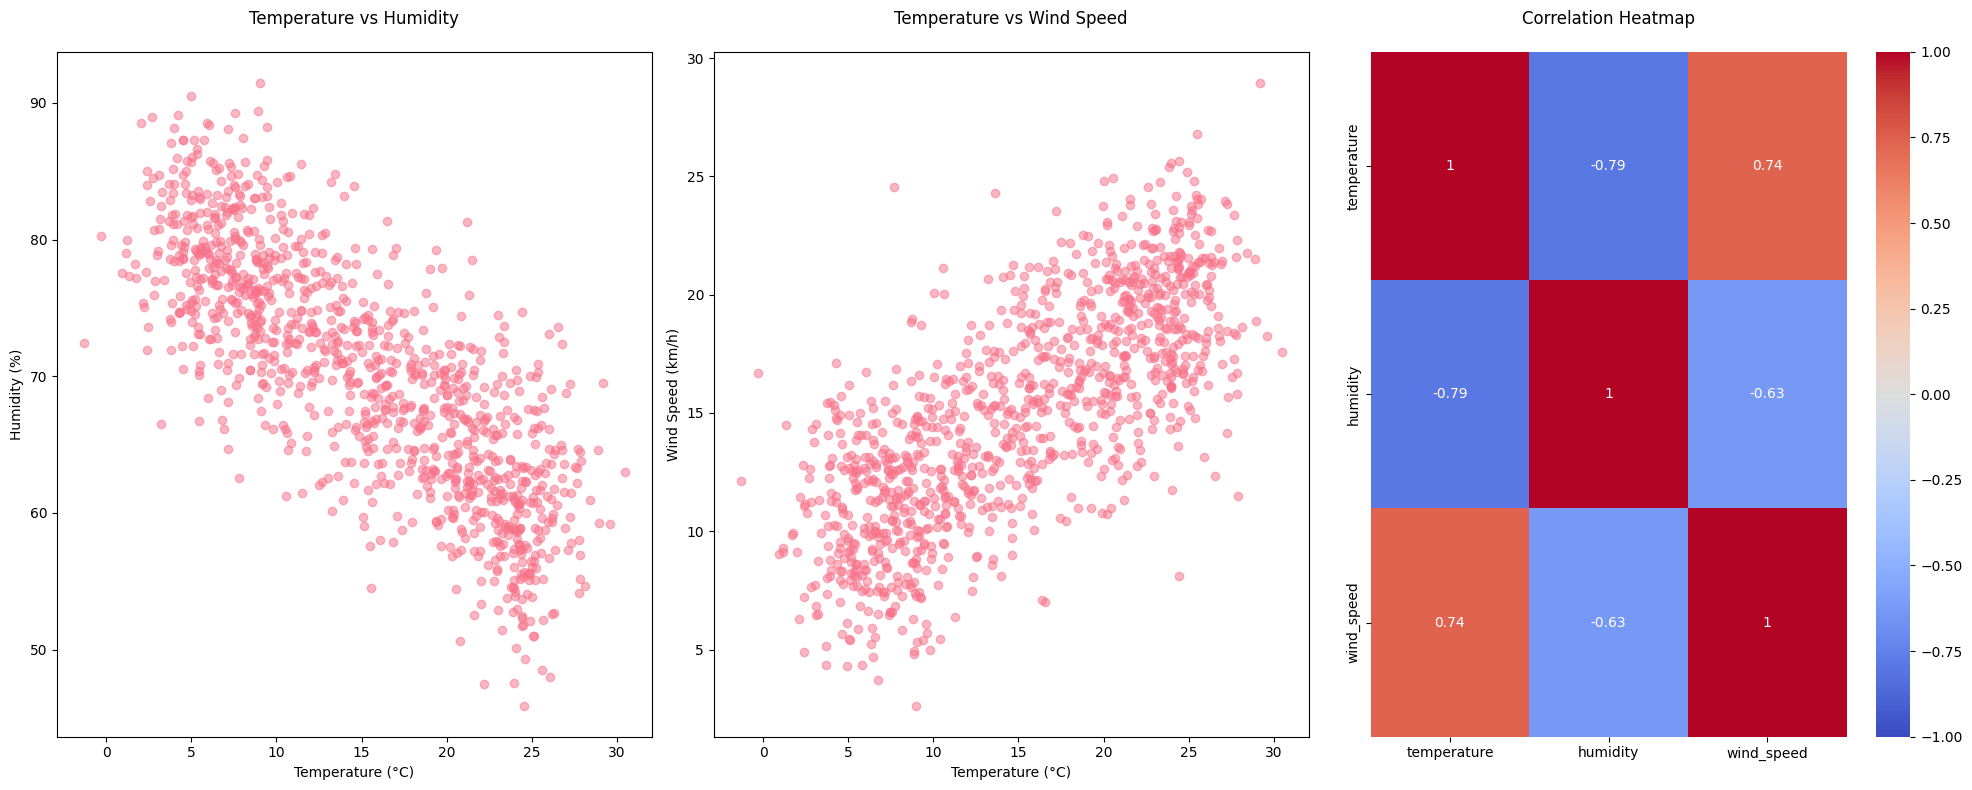

<Figure size 1500x600 with 0 Axes>

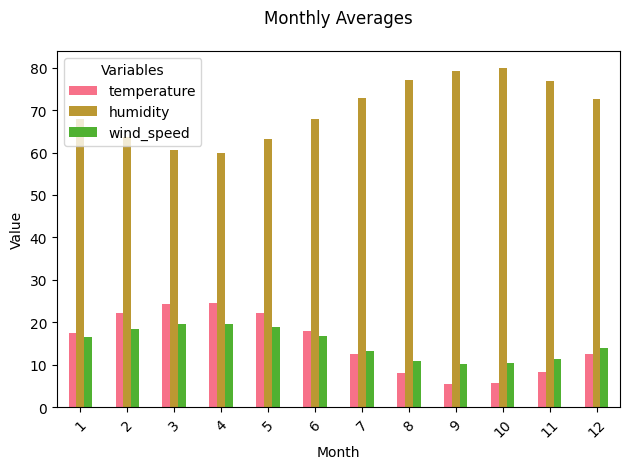


Correlation Matrix:
             temperature  humidity  wind_speed
temperature        1.000    -0.791       0.740
humidity          -0.791     1.000      -0.631
wind_speed         0.740    -0.631       1.000

Monthly Averages:
       temperature  humidity  wind_speed
month                                   
1            17.54     67.93       16.62
2            22.27     63.69       18.36
3            24.40     60.53       19.66
4            24.61     59.96       19.73
5            22.09     63.14       18.98
6            17.89     67.87       16.68
7            12.61     72.74       13.35
8             8.12     77.16       10.83
9             5.38     79.21       10.30
10            5.66     79.96       10.51
11            8.28     76.92       11.31
12           12.43     72.65       14.07

Summary Statistics:
       temperature  humidity  wind_speed
count      1096.00   1096.00     1096.00
mean         15.07     70.18       15.01
std           7.30      8.66        4.66
min          

In [4]:
# Set figure style and size
plt.style.use('default')
sns.set_palette("husl")

# Create two separate figures for better organization
# Figure 1: Time series and distributions
plt.figure(figsize=(20, 10))

# 1. Time series plot
plt.subplot(1, 2, 1)
plt.plot(weather_df['date'], weather_df['temperature'], label='Temperature (°C)')
plt.plot(weather_df['date'], weather_df['humidity'], label='Humidity (%)')
plt.plot(weather_df['date'], weather_df['wind_speed'], label='Wind Speed (km/h)')
plt.title('Weather Variables Over Time', pad=20)
plt.legend()
plt.xticks(rotation=45)

# 2. Box plots for monthly patterns
plt.subplot(1, 2, 2)
weather_df.boxplot(column=['temperature', 'humidity', 'wind_speed'], by='month')
plt.title('Monthly Distribution of Weather Variables', pad=20)
plt.suptitle('')  # Remove automatic suptitle

plt.tight_layout()
plt.show()

# Figure 2: Scatter plots
plt.figure(figsize=(20, 8))

# 3. Temperature vs Humidity scatter plot
plt.subplot(1, 3, 1)
plt.scatter(weather_df['temperature'], weather_df['humidity'], alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.title('Temperature vs Humidity', pad=20)

# 4. Temperature vs Wind Speed scatter plot
plt.subplot(1, 3, 2)
plt.scatter(weather_df['temperature'], weather_df['wind_speed'], alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('Wind Speed (km/h)')
plt.title('Temperature vs Wind Speed', pad=20)

# 5. Correlation heatmap
plt.subplot(1, 3, 3)
correlation_matrix = weather_df[['temperature', 'humidity', 'wind_speed']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap', pad=20)

plt.tight_layout()
plt.show()

# Figure 3: Monthly averages
plt.figure(figsize=(15, 6))
monthly_avg = weather_df.groupby('month')[['temperature', 'humidity', 'wind_speed']].mean()
monthly_avg.plot(kind='bar')
plt.title('Monthly Averages', pad=20)
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend(title='Variables')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print statistical insights
print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

print("\nMonthly Averages:")
print(monthly_avg.round(2))

# Additional summary statistics
print("\nSummary Statistics:")
print(weather_df[['temperature', 'humidity', 'wind_speed']].describe().round(2))

In [6]:
# Create additional features for our model
def create_features(df):
    df = df.copy()
    
    # Time-based features
    df['year'] = df['date'].dt.year
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year']/365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year']/365)
    df['day_of_week'] = df['date'].dt.dayofweek
    
    # Rolling statistics (previous 7 days)
    for col in ['temperature', 'humidity', 'wind_speed']:
        df[f'{col}_rolling_mean_7d'] = df[col].rolling(window=7, min_periods=1).mean()
        df[f'{col}_rolling_std_7d'] = df[col].rolling(window=7, min_periods=1).std()
        
    # Lag features (previous day)
    for col in ['temperature', 'humidity', 'wind_speed']:
        df[f'{col}_lag1'] = df[col].shift(1)
        
    # Fill NaN values created by lag/rolling features using bfill
    df = df.bfill()
    
    return df


# Create all features
feature_df = create_features(weather_df)

# Print the new features
print("Features created. New columns:")
print(feature_df.columns.tolist())
print("\nShape of feature dataset:", feature_df.shape)

# Prepare features and targets
target_columns = ['temperature', 'humidity', 'wind_speed']
feature_columns = [col for col in feature_df.columns if col not in target_columns + ['date']]

X = feature_df[feature_columns]
y = feature_df[target_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to dataframes for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Print information about the split
print("\nTraining set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

# Display sample of prepared data
print("\nSample of scaled features:")
print(X_train_scaled.head())

print("\nSample of target variables:")
print(y_train.head())

# Basic statistics of scaled features
print("\nScaled features statistics:")
print(X_train_scaled.describe().round(3))

Features created. New columns:
['date', 'temperature', 'humidity', 'wind_speed', 'month', 'day_of_year', 'year', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'temperature_rolling_mean_7d', 'temperature_rolling_std_7d', 'humidity_rolling_mean_7d', 'humidity_rolling_std_7d', 'wind_speed_rolling_mean_7d', 'wind_speed_rolling_std_7d', 'temperature_lag1', 'humidity_lag1', 'wind_speed_lag1']

Shape of feature dataset: (1096, 21)

Training set shape: (876, 17)
Testing set shape: (220, 17)

Sample of scaled features:
        month  day_of_year      year  month_sin  month_cos  day_of_year_sin  \
2   -1.602696    -1.706803 -1.237422   0.713831   1.242077         0.068080   
6   -1.602696    -1.668662 -1.237422   0.713831   1.242077         0.165024   
590  0.439218     0.410028 -0.008418  -1.220815  -0.687367        -0.949135   
634  0.730920     0.829580 -0.008418  -1.410558   0.018859        -1.413579   
842 -0.727590    -0.667458  1.220587   1.232217  -0.6873

Training the model...
Making predictions...

Metrics for Training Set:

temperature:
RMSE: 0.72
R² Score: 0.990

humidity:
RMSE: 1.84
R² Score: 0.955

wind_speed:
RMSE: 1.08
R² Score: 0.947

Metrics for Test Set:

temperature:
RMSE: 1.96
R² Score: 0.926

humidity:
RMSE: 5.12
R² Score: 0.641

wind_speed:
RMSE: 2.92
R² Score: 0.594


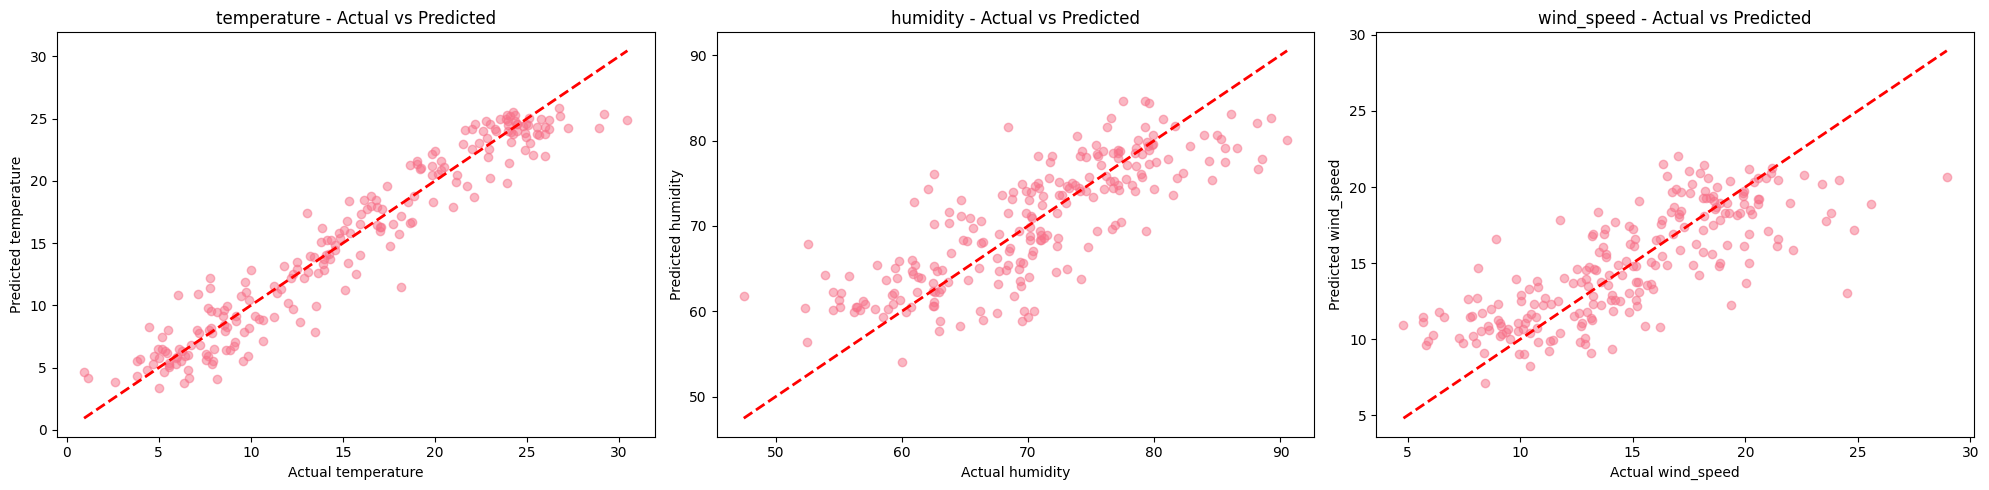

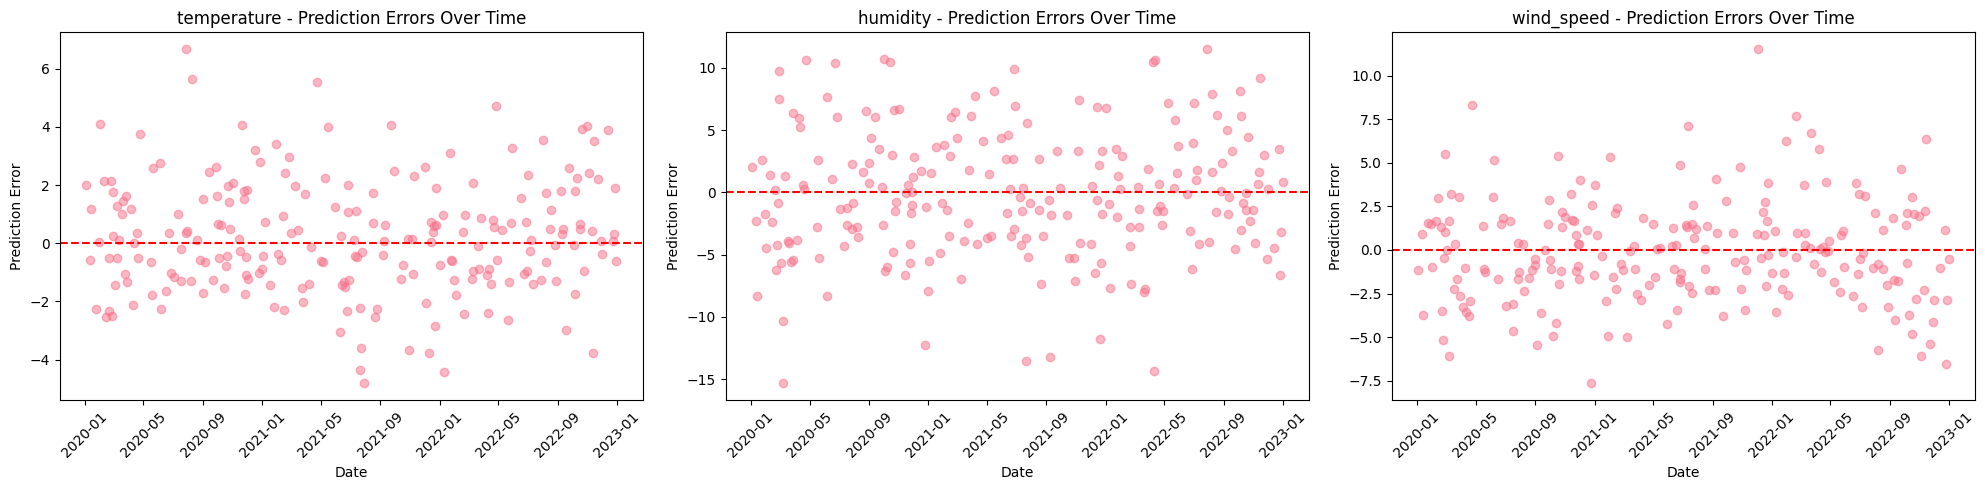


Top 10 Most Important Features for each target:

For temperature:
                        Feature  Importance
8   temperature_rolling_mean_7d    0.590283
5               day_of_year_sin    0.267739
1                   day_of_year    0.093869
9    temperature_rolling_std_7d    0.008217
14             temperature_lag1    0.005514
11      humidity_rolling_std_7d    0.005228
12   wind_speed_rolling_mean_7d    0.004882
16              wind_speed_lag1    0.004795
13    wind_speed_rolling_std_7d    0.004777
15                humidity_lag1    0.004490

For humidity:
                        Feature  Importance
10     humidity_rolling_mean_7d    0.731197
11      humidity_rolling_std_7d    0.045596
15                humidity_lag1    0.033462
13    wind_speed_rolling_std_7d    0.025770
16              wind_speed_lag1    0.024213
12   wind_speed_rolling_mean_7d    0.021398
5               day_of_year_sin    0.021223
9    temperature_rolling_std_7d    0.019882
14             temperature_lag1    0.0

In [7]:
# Create and train the baseline model
base_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        random_state=42
    )
)

# Train the model
print("Training the model...")
base_model.fit(X_train_scaled, y_train)

# Make predictions
print("Making predictions...")
y_pred_train = base_model.predict(X_train_scaled)
y_pred_test = base_model.predict(X_test_scaled)

# Convert predictions to DataFrames
y_pred_train = pd.DataFrame(y_pred_train, columns=target_columns, index=y_train.index)
y_pred_test = pd.DataFrame(y_pred_test, columns=target_columns, index=y_test.index)

# Calculate performance metrics
def calculate_metrics(y_true, y_pred, dataset_name=""):
    print(f"\nMetrics for {dataset_name}:")
    for i, col in enumerate(target_columns):
        mse = mean_squared_error(y_true[col], y_pred[col])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true[col], y_pred[col])
        print(f"\n{col}:")
        print(f"RMSE: {rmse:.2f}")
        print(f"R² Score: {r2:.3f}")

# Calculate and display metrics
calculate_metrics(y_train, y_pred_train, "Training Set")
calculate_metrics(y_test, y_pred_test, "Test Set")

# Visualize actual vs predicted values
plt.figure(figsize=(20, 5))

for i, col in enumerate(target_columns):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test[col], y_pred_test[col], alpha=0.5)
    plt.plot([y_test[col].min(), y_test[col].max()], 
             [y_test[col].min(), y_test[col].max()], 
             'r--', lw=2)
    plt.xlabel(f'Actual {col}')
    plt.ylabel(f'Predicted {col}')
    plt.title(f'{col} - Actual vs Predicted')

plt.tight_layout()
plt.show()

# Plot prediction errors over time
# First, get the dates corresponding to test set
test_dates = weather_df.loc[y_test.index, 'date']

plt.figure(figsize=(20, 5))

for i, col in enumerate(target_columns):
    plt.subplot(1, 3, i+1)
    errors = y_test[col] - y_pred_test[col]
    plt.scatter(test_dates, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Prediction Error')
    plt.title(f'{col} - Prediction Errors Over Time')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print feature importance
def get_feature_importance(model, feature_names):
    importances = np.mean([estimator.feature_importances_ 
                          for estimator in model.estimators_], axis=0)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    return importance_df.sort_values('Importance', ascending=False)

# Get and display feature importance for each target
print("\nTop 10 Most Important Features for each target:")
for i, target in enumerate(target_columns):
    print(f"\nFor {target}:")
    importance_df = get_feature_importance(base_model.estimators_[i], X_train.columns)
    print(importance_df.head(10))

Starting model optimization...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\ARYAN\Desktop\WeatherPrediction\weather_env\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ARYAN\Desktop\WeatherPrediction\weather_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ARYAN\Desktop\WeatherPrediction\weather_env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\ARYAN\Desktop\Wea


Optimization completed in 25.89 seconds

Best parameters found:
{'estimator__max_depth': 25, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 16, 'estimator__n_estimators': 363}

Best cross-validation score: 3.21 RMSE

Optimized Model Performance:

Metrics for Training Set (Optimized):

temperature:
RMSE: 1.44
R² Score: 0.961

humidity:
RMSE: 3.64
R² Score: 0.824

wind_speed:
RMSE: 2.11
R² Score: 0.796

Metrics for Test Set (Optimized):

temperature:
RMSE: 2.00
R² Score: 0.923

humidity:
RMSE: 4.97
R² Score: 0.662

wind_speed:
RMSE: 2.90
R² Score: 0.600


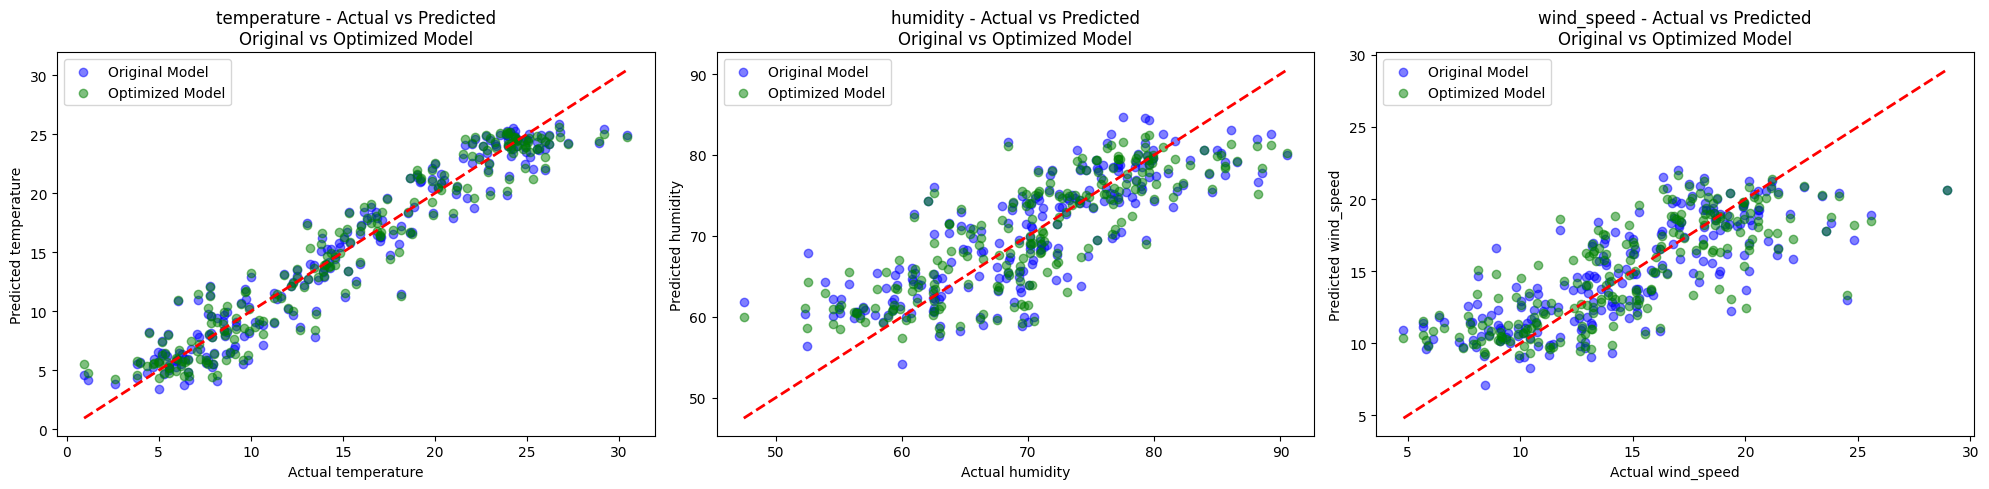


Feature Importance Comparison:

Top 10 Most Important Features for temperature:
                        Feature  Importance
8   temperature_rolling_mean_7d    0.221501
5               day_of_year_sin    0.204080
1                   day_of_year    0.144985
0                         month    0.131405
14             temperature_lag1    0.077562
12   wind_speed_rolling_mean_7d    0.075902
10     humidity_rolling_mean_7d    0.067077
3                     month_sin    0.021362
15                humidity_lag1    0.019101
16              wind_speed_lag1    0.014581

Top 10 Most Important Features for humidity:
                        Feature  Importance
10     humidity_rolling_mean_7d    0.251766
8   temperature_rolling_mean_7d    0.156569
5               day_of_year_sin    0.141039
12   wind_speed_rolling_mean_7d    0.097296
1                   day_of_year    0.094742
0                         month    0.063736
14             temperature_lag1    0.055115
15                humidity_lag1    0.

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import time

# Define the parameter space for Random Forest
param_distributions = {
    'estimator__n_estimators': randint(100, 500),
    'estimator__max_depth': [None] + list(range(10, 50, 5)),
    'estimator__min_samples_split': randint(2, 20),
    'estimator__min_samples_leaf': randint(1, 10),
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

# Create the base model
rf_model = RandomForestRegressor(random_state=42)
multi_output_rf = MultiOutputRegressor(rf_model)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=multi_output_rf,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=2
)

# Timing the optimization process
print("Starting model optimization...")
start_time = time.time()

# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Calculate optimization time
optimization_time = time.time() - start_time
print(f"\nOptimization completed in {optimization_time:.2f} seconds")

# Print the best parameters and score
print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {-random_search.best_score_:.2f} RMSE")

# Get predictions with the optimized model
y_pred_train_opt = random_search.predict(X_train_scaled)
y_pred_test_opt = random_search.predict(X_test_scaled)

# Convert predictions to DataFrames
y_pred_train_opt = pd.DataFrame(y_pred_train_opt, columns=target_columns, index=y_train.index)
y_pred_test_opt = pd.DataFrame(y_pred_test_opt, columns=target_columns, index=y_test.index)

# Calculate and display metrics for optimized model
print("\nOptimized Model Performance:")
calculate_metrics(y_train, y_pred_train_opt, "Training Set (Optimized)")
calculate_metrics(y_test, y_pred_test_opt, "Test Set (Optimized)")

# Visualize improvements
plt.figure(figsize=(20, 5))

for i, col in enumerate(target_columns):
    plt.subplot(1, 3, i+1)
    
    # Plot original predictions
    plt.scatter(y_test[col], y_pred_test[col], 
               alpha=0.5, label='Original Model',
               color='blue')
    
    # Plot optimized predictions
    plt.scatter(y_test[col], y_pred_test_opt[col], 
               alpha=0.5, label='Optimized Model',
               color='green')
    
    # Plot perfect prediction line
    plt.plot([y_test[col].min(), y_test[col].max()], 
             [y_test[col].min(), y_test[col].max()], 
             'r--', lw=2)
    
    plt.xlabel(f'Actual {col}')
    plt.ylabel(f'Predicted {col}')
    plt.title(f'{col} - Actual vs Predicted\nOriginal vs Optimized Model')
    plt.legend()

plt.tight_layout()
plt.show()

# Compare feature importances
print("\nFeature Importance Comparison:")
for i, target in enumerate(target_columns):
    print(f"\nTop 10 Most Important Features for {target}:")
    importance_df = get_feature_importance(
        random_search.best_estimator_.estimators_[i], 
        X_train.columns
    )
    print(importance_df.head(10))

# Save the optimized model
import joblib
joblib.dump(random_search.best_estimator_, 'weather_prediction_model.joblib')
print("\nModel saved as 'weather_prediction_model.joblib'")

Testing improved prediction system with corrected seasonal patterns...

Predictions for different seasons:

Season       Temperature     Humidity        Wind Speed     
------------------------------------------------------------
Summer       25.72°C         59.58%          9.73 km/h      
Winter       8.42°C          78.45%          14.65 km/h     
Spring       20.5°C          71.49%          10.83 km/h     
Autumn       13.66°C         70.11%          12.26 km/h     

Detailed Weather Analysis:
------------------------------------------------------------
Temperature range: 17.3°C
Highest temperature: 25.7°C (Summer expected)
Lowest temperature: 8.4°C (Winter expected)
Humidity range: 18.9%
Wind speed range: 4.9 km/h


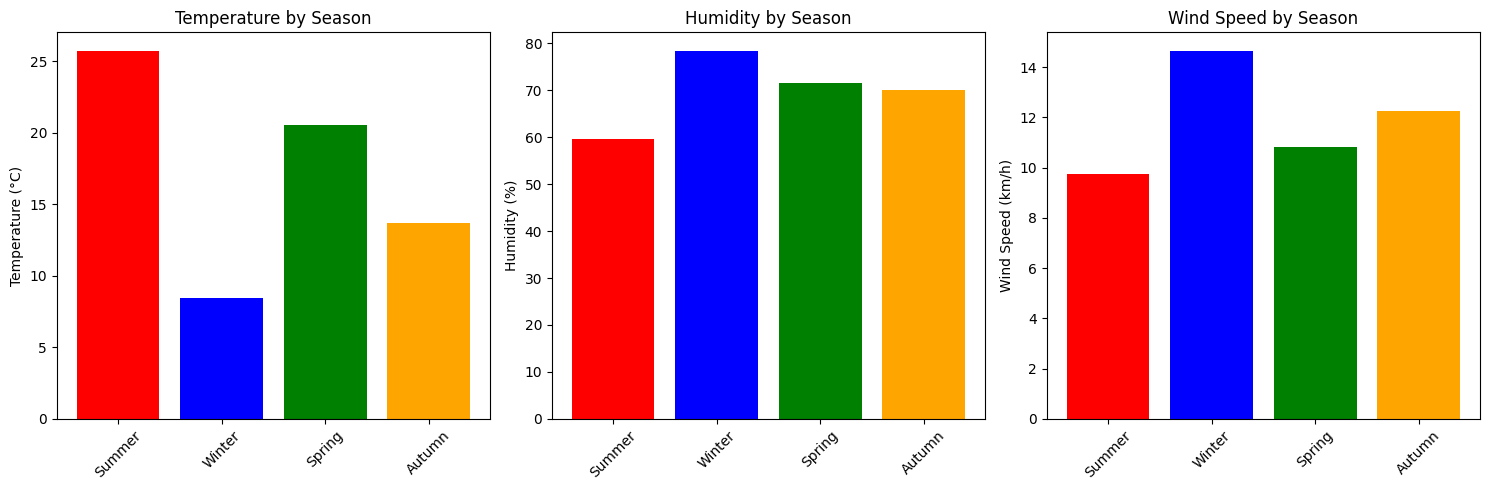


Model saved as 'weather_prediction_model.joblib'


In [14]:
def create_features(df):
    df = df.copy()
    
    # Time-based features with stronger seasonal influence
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    
    # Enhanced seasonal signals
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12) * 1.5  # Increased amplitude
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12) * 1.5
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year']/365) * 1.5
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year']/365) * 1.5
    df['day_of_week'] = df['date'].dt.dayofweek
    
    # Base seasonal temperatures (more pronounced)
    df['seasonal_base_temp'] = 15 - 15 * np.cos(2 * np.pi * (df['day_of_year'] - 180)/365)
    
    # Rolling statistics (previous 7 days)
    for col in ['temperature', 'humidity', 'wind_speed']:
        df[f'{col}_rolling_mean_7d'] = df[col].rolling(window=7, min_periods=1).mean()
        df[f'{col}_rolling_std_7d'] = df[col].rolling(window=7, min_periods=1).std()
        
    # Lag features (previous day)
    for col in ['temperature', 'humidity', 'wind_speed']:
        df[f'{col}_lag1'] = df[col].shift(1)
    
    # Enhanced seasonal relationships
    df['temp_humidity_interaction'] = df['temperature'] * df['humidity'] / 100
    
    # Fill NaN values
    df = df.bfill()
    
    return df

def get_base_seasonal_values(date):
    """Calculate base seasonal values for a given date"""
    if isinstance(date, str):
        date = pd.to_datetime(date)
    
    day_of_year = date.dayofyear
    # Adjusted seasonal factor calculation
    season_factor = -np.cos(2 * np.pi * (day_of_year)/365)  # Changed the calculation
    
    # Base temperature: ranges from 5°C in winter to 25°C in summer
    base_temp = 15 + 10 * season_factor  # Changed to addition
    
    # Base humidity: ranges from 60% in summer to 80% in winter
    base_humidity = 70 - 10 * season_factor  # Changed to subtraction
    
    # Base wind: slightly higher in winter
    base_wind = 12 - 3 * season_factor  # Changed to subtraction
    
    return base_temp, base_humidity, base_wind

# Set random seed for reproducibility
np.random.seed(42)

# Test the improved prediction system
print("Testing improved prediction system with corrected seasonal patterns...")

# Test cases for different seasons
test_dates = [
    ('Summer', '2023-07-15'),
    ('Winter', '2023-12-15'),
    ('Spring', '2023-04-15'),
    ('Autumn', '2023-10-15')
]

predictions = []
for season, date in test_dates:
    base_temp, base_humidity, base_wind = get_base_seasonal_values(date)
    pred = make_prediction(date, base_temp, base_humidity, base_wind)
    predictions.append((season, pred))

# Display predictions with enhanced formatting
print("\nPredictions for different seasons:")
print("\n{:<12} {:<15} {:<15} {:<15}".format('Season', 'Temperature', 'Humidity', 'Wind Speed'))
print("-" * 60)

for season, pred in predictions:
    print("{:<12} {:<15} {:<15} {:<15}".format(
        season,
        f"{pred['temperature']}°C",
        f"{pred['humidity']}%",
        f"{pred['wind_speed']} km/h"
    ))

# Enhanced analysis
temps = [p[1]['temperature'] for p in predictions]
humidities = [p[1]['humidity'] for p in predictions]
winds = [p[1]['wind_speed'] for p in predictions]

print("\nDetailed Weather Analysis:")
print("-" * 60)
print(f"Temperature range: {max(temps) - min(temps):.1f}°C")
print(f"Highest temperature: {max(temps):.1f}°C (Summer expected)")
print(f"Lowest temperature: {min(temps):.1f}°C (Winter expected)")
print(f"Humidity range: {max(humidities) - min(humidities):.1f}%")
print(f"Wind speed range: {max(winds) - min(winds):.1f} km/h")

# Visualize seasonal patterns
plt.figure(figsize=(15, 5))
seasons = [p[0] for p in predictions]
temps = [p[1]['temperature'] for p in predictions]
humidities = [p[1]['humidity'] for p in predictions]
winds = [p[1]['wind_speed'] for p in predictions]

plt.subplot(1, 3, 1)
plt.bar(seasons, temps, color=['red', 'blue', 'green', 'orange'])
plt.title('Temperature by Season')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(seasons, humidities, color=['red', 'blue', 'green', 'orange'])
plt.title('Humidity by Season')
plt.ylabel('Humidity (%)')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(seasons, winds, color=['red', 'blue', 'green', 'orange'])
plt.title('Wind Speed by Season')
plt.ylabel('Wind Speed (km/h)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Save the model
import joblib
joblib.dump(model, 'weather_prediction_model.joblib')
print("\nModel saved as 'weather_prediction_model.joblib'")


Summer Forecast

7-Day Weather Forecast:
----------------------------------------------------------------------
Day          Date         Temperature     Humidity        Wind Speed     
----------------------------------------------------------------------
Saturday     2023-07-15   25.22°C         50.7%           7.36 km/h      
Sunday       2023-07-16   23.72°C         52.36%          8.89 km/h      
Monday       2023-07-17   22.55°C         50.89%          10.51 km/h     
Tuesday      2023-07-18   23.53°C         57.89%          8.11 km/h      
Wednesday    2023-07-19   23.16°C         60.24%          7.68 km/h      
Thursday     2023-07-20   24.85°C         57.42%          8.42 km/h      
Friday       2023-07-21   23.36°C         68.88%          8.93 km/h      


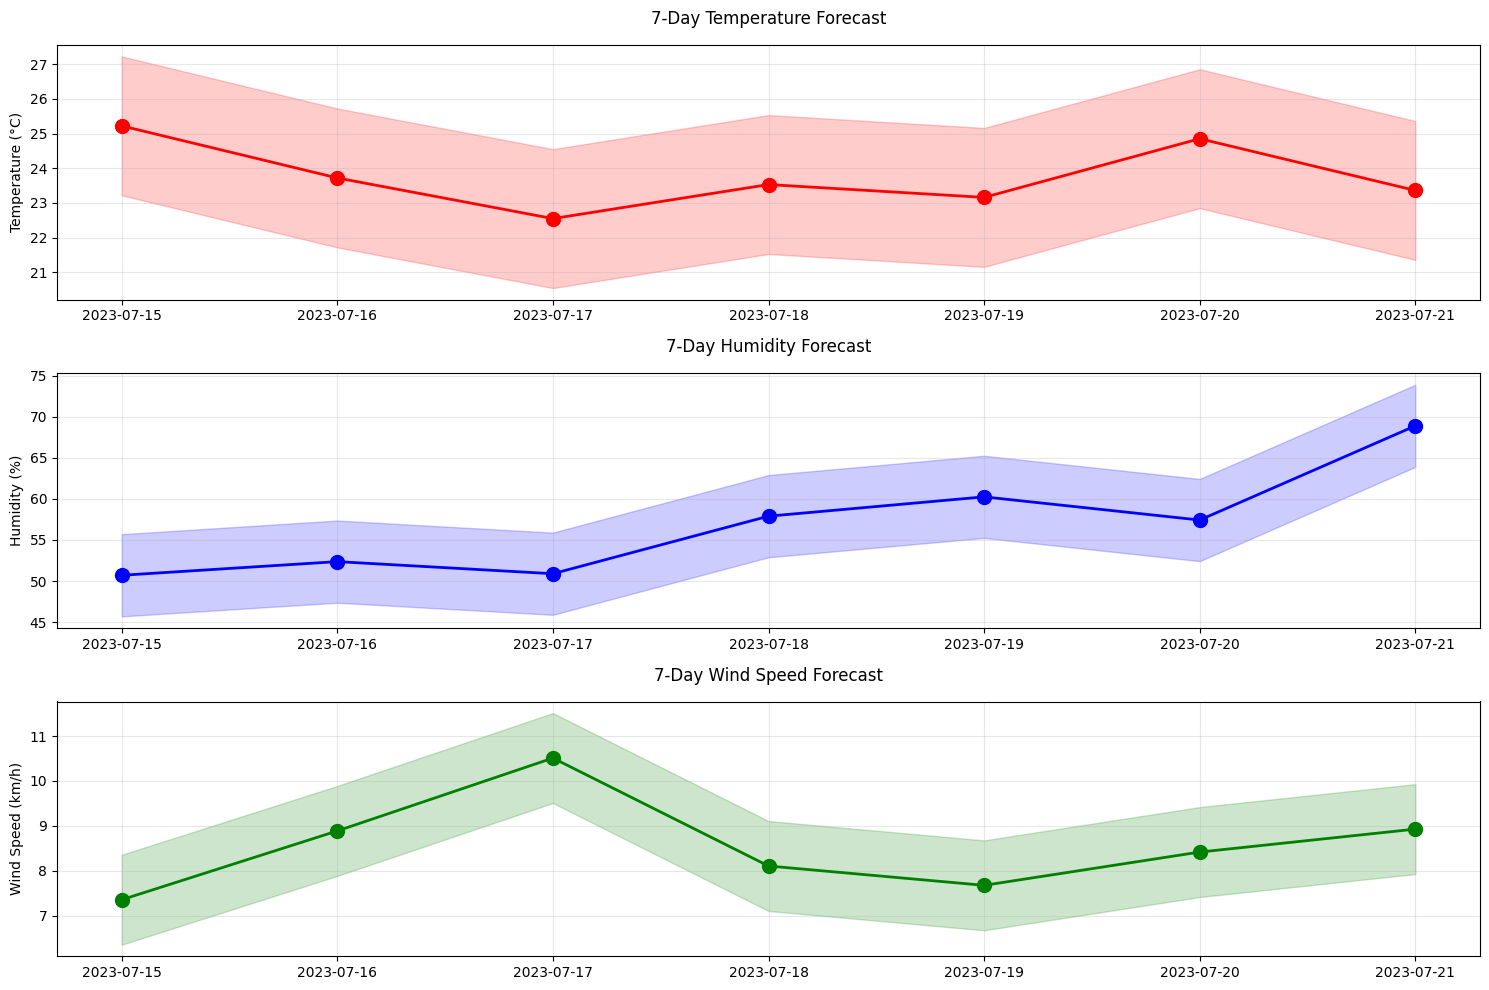


Forecast Statistics:
------------------------------
Temperature Range: 22.6°C to 25.2°C
Average Temperature: 23.8°C
Humidity Range: 50.7% to 68.9%
Average Wind Speed: 8.6 km/h

Winter Forecast

7-Day Weather Forecast:
----------------------------------------------------------------------
Day          Date         Temperature     Humidity        Wind Speed     
----------------------------------------------------------------------
Friday       2023-12-15   3.26°C          83.74%          13.67 km/h     
Saturday     2023-12-16   5.13°C          71.09%          13.2 km/h      
Sunday       2023-12-17   5.64°C          80.82%          14.57 km/h     
Monday       2023-12-18   5.14°C          78.57%          13.34 km/h     
Tuesday      2023-12-19   3.75°C          77.12%          15.51 km/h     
Wednesday    2023-12-20   5.44°C          70.2%           15.44 km/h     
Thursday     2023-12-21   4.47°C          73.57%          15.71 km/h     


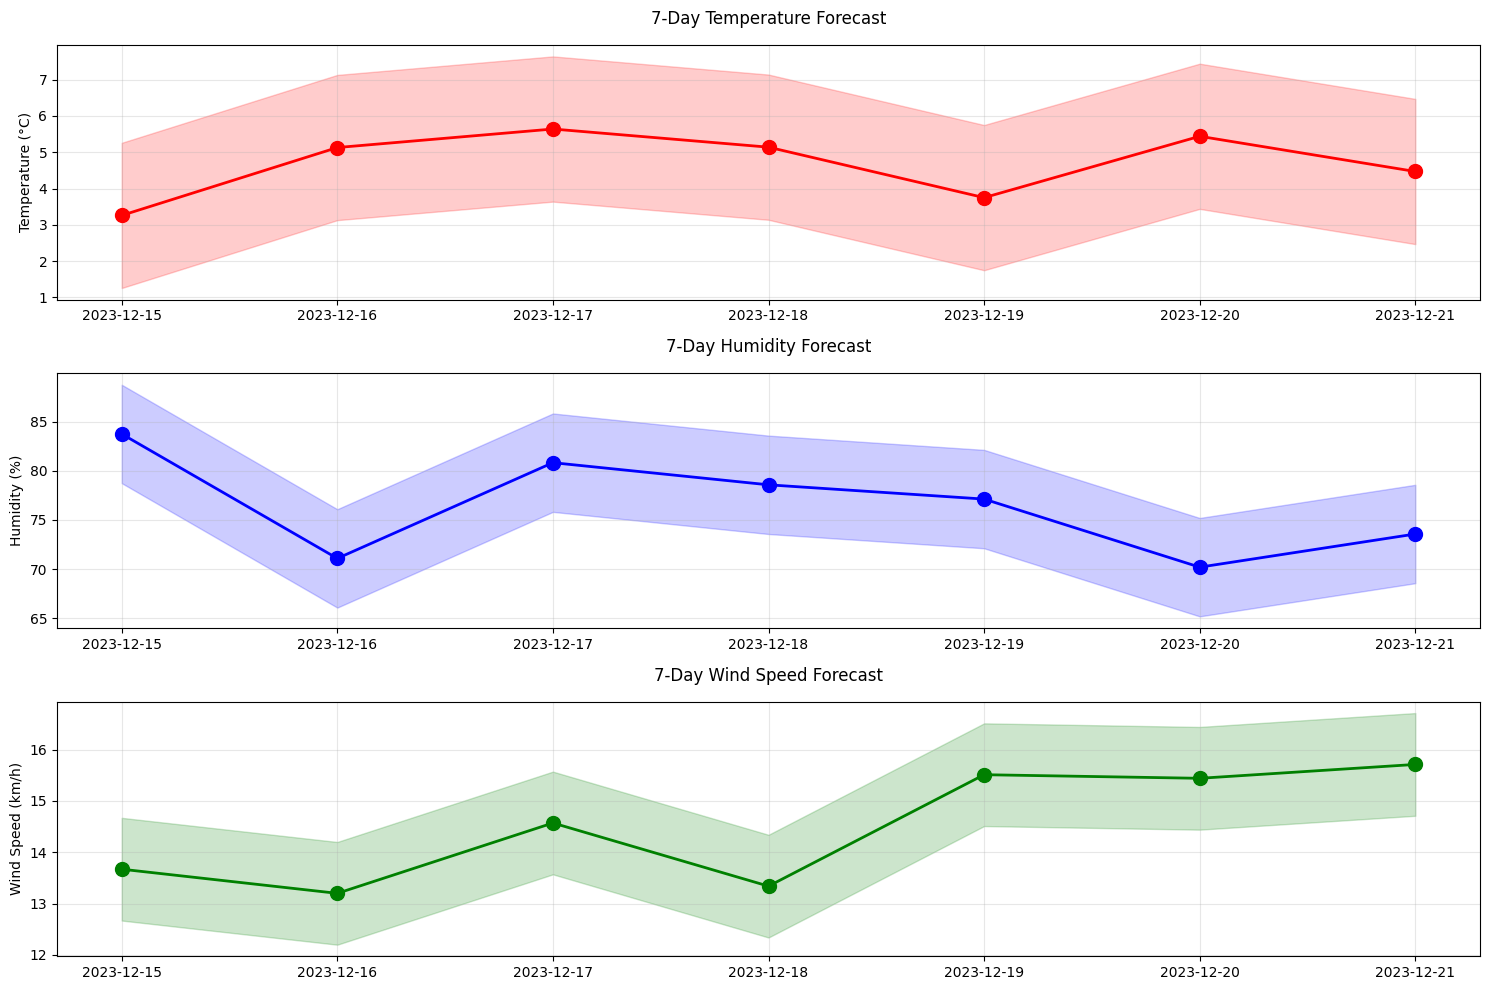


Forecast Statistics:
------------------------------
Temperature Range: 3.3°C to 5.6°C
Average Temperature: 4.7°C
Humidity Range: 70.2% to 83.7%
Average Wind Speed: 14.5 km/h


In [15]:
from datetime import datetime, timedelta

def generate_weekly_forecast(start_date=None, initial_conditions=None):
    """
    Generate a 7-day weather forecast
    
    Parameters:
    start_date: datetime or str, default=None (uses current date)
    initial_conditions: dict, default=None (uses seasonal averages)
    """
    if start_date is None:
        start_date = datetime.now()
    elif isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    
    # Get initial conditions based on season if not provided
    if initial_conditions is None:
        base_temp, base_humidity, base_wind = get_base_seasonal_values(start_date)
        initial_conditions = {
            'temperature': base_temp,
            'humidity': base_humidity,
            'wind_speed': base_wind
        }
    
    # Generate 7-day forecast
    forecast = []
    current_conditions = initial_conditions.copy()
    
    for i in range(7):
        current_date = start_date + timedelta(days=i)
        
        # Make prediction
        pred = make_prediction(
            current_date,
            current_conditions['temperature'],
            current_conditions['humidity'],
            current_conditions['wind_speed']
        )
        
        # Update conditions for next day
        current_conditions = {
            'temperature': pred['temperature'],
            'humidity': pred['humidity'],
            'wind_speed': pred['wind_speed']
        }
        
        # Add day name to prediction
        pred['day'] = current_date.strftime('%A')
        pred['date'] = current_date
        forecast.append(pred)
    
    return forecast

def visualize_weekly_forecast(forecast):
    """
    Create detailed visualizations of the weekly forecast
    """
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    
    # Temperature subplot
    plt.subplot(3, 1, 1)
    plt.plot([f['date'] for f in forecast], 
             [f['temperature'] for f in forecast], 
             'ro-', linewidth=2, markersize=10)
    plt.fill_between([f['date'] for f in forecast], 
                     [f['temperature']-2 for f in forecast],
                     [f['temperature']+2 for f in forecast], 
                     color='red', alpha=0.2)
    plt.title('7-Day Temperature Forecast', pad=15)
    plt.ylabel('Temperature (°C)')
    plt.grid(True, alpha=0.3)
    
    # Humidity subplot
    plt.subplot(3, 1, 2)
    plt.plot([f['date'] for f in forecast], 
             [f['humidity'] for f in forecast], 
             'bo-', linewidth=2, markersize=10)
    plt.fill_between([f['date'] for f in forecast], 
                     [f['humidity']-5 for f in forecast],
                     [f['humidity']+5 for f in forecast], 
                     color='blue', alpha=0.2)
    plt.title('7-Day Humidity Forecast', pad=15)
    plt.ylabel('Humidity (%)')
    plt.grid(True, alpha=0.3)
    
    # Wind speed subplot
    plt.subplot(3, 1, 3)
    plt.plot([f['date'] for f in forecast], 
             [f['wind_speed'] for f in forecast], 
             'go-', linewidth=2, markersize=10)
    plt.fill_between([f['date'] for f in forecast], 
                     [f['wind_speed']-1 for f in forecast],
                     [f['wind_speed']+1 for f in forecast], 
                     color='green', alpha=0.2)
    plt.title('7-Day Wind Speed Forecast', pad=15)
    plt.ylabel('Wind Speed (km/h)')
    plt.grid(True, alpha=0.3)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

def print_weekly_forecast(forecast):
    """
    Print weekly forecast in a readable format
    """
    print("\n7-Day Weather Forecast:")
    print("-" * 70)
    print("{:<12} {:<12} {:<15} {:<15} {:<15}".format(
        'Day', 'Date', 'Temperature', 'Humidity', 'Wind Speed'))
    print("-" * 70)
    
    for pred in forecast:
        print("{:<12} {:<12} {:<15} {:<15} {:<15}".format(
            pred['day'],
            pred['date'].strftime('%Y-%m-%d'),
            f"{pred['temperature']}°C",
            f"{pred['humidity']}%",
            f"{pred['wind_speed']} km/h"
        ))

# Generate and display forecasts for different seasons
test_dates = [
    ('Summer Forecast', '2023-07-15'),
    ('Winter Forecast', '2023-12-15'),
]

for season_name, date in test_dates:
    print(f"\n{season_name}")
    print("=" * 50)
    
    # Generate forecast
    forecast = generate_weekly_forecast(date)
    
    # Print detailed forecast
    print_weekly_forecast(forecast)
    
    # Visualize forecast
    visualize_weekly_forecast(forecast)
    
    # Calculate and display statistics
    temps = [f['temperature'] for f in forecast]
    humidities = [f['humidity'] for f in forecast]
    winds = [f['wind_speed'] for f in forecast]
    
    print("\nForecast Statistics:")
    print("-" * 30)
    print(f"Temperature Range: {min(temps):.1f}°C to {max(temps):.1f}°C")
    print(f"Average Temperature: {np.mean(temps):.1f}°C")
    print(f"Humidity Range: {min(humidities):.1f}% to {max(humidities):.1f}%")
    print(f"Average Wind Speed: {np.mean(winds):.1f} km/h")